# Problem
The new test for solving pde using pytorch:

$
\frac{\partial{u}}{\partial t} = \kappa (\frac{\partial^2 u}{\partial{x}^2}+\frac{\partial^2 u}{\partial{y}^2}) + S(x,y,t)
$

in the square region $0 \le x \le 2$ and $ 0 \le y \le 2$
for the time $0 \le t \le 2$

Independent variables:
* t - time
* x - coordinate
* y - coordinate

Dependent variables output:
* u - diffusion species

In [12]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict
from torch.autograd import Variable

In [33]:
batch_size = 4096
block_size = 8
batch_size * block_size

32768

In [4]:
# Select a random subset of the coordinates for the mini-batch
x = torch.arange(0, 0.1 + 0.001, 0.001)
num_samples = x.shape[0]
perm = torch.randperm(num_samples)[:batch_size]
minibatch_coords = x[perm]

In [6]:
minibatch_coords

tensor([0.0290, 0.0700, 0.0160, 0.0750, 0.0760, 0.0430, 0.0670, 0.0720, 0.0630,
        0.0890, 0.0240, 0.0510, 0.0930, 0.0020, 0.0120, 0.0580, 0.0790, 0.0200,
        0.0940, 0.0870, 0.0840, 0.0110, 0.0520, 0.0970, 0.0180, 0.0370, 0.0660,
        0.0480, 0.0390, 0.0280, 0.0090, 0.0620, 0.0740, 0.0770, 0.0310, 0.0830,
        0.0030, 0.0690, 0.0060, 0.0990, 0.0560, 0.0070, 0.0250, 0.0170, 0.0800,
        0.0960, 0.0260, 0.0680, 0.0590, 0.0550, 0.0140, 0.0150, 0.0190, 0.0490,
        0.0450, 0.0860, 0.0500, 0.0230, 0.0920, 0.0400, 0.0220, 0.0710, 0.0980,
        0.0540, 0.0910, 0.0880, 0.0950, 0.1000, 0.0640, 0.0530, 0.0470, 0.0780,
        0.0360, 0.0420, 0.0330, 0.0300, 0.0460, 0.0650, 0.0210, 0.0850, 0.0810,
        0.0570, 0.0000, 0.0100, 0.0380, 0.0730, 0.0900, 0.0410, 0.0050, 0.0040,
        0.0010, 0.0270, 0.0080, 0.0820, 0.0320, 0.0130, 0.0600, 0.0350, 0.0610,
        0.0440, 0.0340])

In [34]:
# rewrite in layer, this is rather boilplate code 
class DiffNet(nn.Module):
    def __init__(self, input_size,hidden_size,
                output_size, depth, act=torch.nn.Tanh):
        super(DiffNet, self).__init__()
        
        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))
        for i in range(depth):
            layers.append(
                ('hidden_%d' %i, torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append(('activation_%d' %i,act()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))
        
        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)
    
    def forward(self, X):
        out = self.layers(X)
        return out

In [35]:
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of min to max.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(0., 0.1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [36]:
class MyDataset(Dataset):
    def __init__(self, sidelength):
        self.N_src_samples = 1000
        self.velocity = 0.02
        self.r0 = 0.005
        self.source_coords = torch.tensor([0.05,0.05])
        self.coords = get_mgrid(sidelength, 3)
        
    def __len__(self):
        return self.coords.shape[0]
    
    def __getitem__(self,idx):
        N_src_samples = self.N_src_samples
        sample_source_coords = torch.zeros(N_src_samples, 2)
        sample_source_coords_r = 2*self.r0 * torch.rand(N_src_samples,1).sqrt()
        sample_source_coords_theta = 2 * np.pi * torch.rand(N_src_samples, 1)
        sample_source_coords_x = sample_source_coords_r * torch.cos(sample_source_coords_theta) \
                                + self.source_coords[0]
        sample_source_coords_y = sample_source_coords_r * torch.sin(sample_source_coords_theta) \
                                + self.source_coords[1]
        sample_source_coords = torch.cat([sample_source_coords_x, sample_source_coords_y],dim=1)
        
        self.coords[-N_src_samples:, :2] = sample_source_coords
        #print(f"source coords: {sample_source_coords}")
        #print(f"coords: {self.coords[-N_src_samples:,:2]}")
        # self.coords.requires_grad = True
        return self.coords[idx]
        
    

Generate the points for dataset

In [10]:
import sobol_seq
def generator_points(samples, dim, random_seed, type_of_points, boundary):
    
    if type_of_points == "sobol":
        print(type_of_points)
        skip = random_seed
        data = np.full((samples, dim), np.nan)
        for j in range(samples):
            seed = j + skip
            data[j, :], next_seed = sobol_seq.i4_sobol(dim, seed)
        return torch.from_numpy(data).type(torch.FloatTensor)
    
    elif type_of_points == "moving_center":
        print(type_of_points)
        skip = random_seed
        '''pts=1 #how many centered points per step
        step=1 #how many time steps in center'''
        # prob=0.25 #factor on how large the randomness of the center points is: 0= 100% centered, 1=completely random
        ring_thick = 0.3
        s_ring_rad = 0.0
        exponent = 1
        n=int(samples/10) #number of total center-bias points

        x0=1 #start of the laser
        xspeed=1.5 #speed of the laser in mm/t_max
        xsize=2.8 #total length of domain
        x0=x0/xsize #normed between one and 0
        xspeed=xspeed/xsize #normed to the size of the domain

        #CHANGE IF YOU CHANGE THE BUFFER Time (minimum extrema of t)!
        t0=0.1 #buffer time

        tlaser=1 #time the laser is actually on
        sum=t0+tlaser
        t0=t0/sum #normed for scaling
        tlaser=tlaser/sum #normed for scaling

        datat = np.full((samples, 1), np.nan)
        dataX = np.full((samples, 1), np.nan)
        dataY = np.full((samples, 1), np.nan)
        dataZ = np.full((samples, 1), np.nan)
        dataP = np.full((samples, dim-4), np.nan)
        i=0
        p=1

        dataY[:, 0] = np.random.laplace(0.5, 1 / 12., samples)
        dataZ[:, 0] = np.random.beta(5, 1, samples)
        for j in range(samples-n-1): #majority of coll points sampled around laser
            seed = j + skip
            rnd, next_seed = sobol_seq.i4_sobol(dim-3, seed)
            datat[j, :]=rnd[0]**exponent
            dataX[j,:] = np.random.triangular(0,x0+datat[j, :]*xspeed, 1)
            if (dim > 4):
                dataP[j, :] = rnd[1:]
        for j in range(samples - n-1, samples): #Center-bias: some points directly in laser center
            seed = j + skip
            rnd, next_seed = sobol_seq.i4_sobol(dim, seed)
            datat[j, :] = rnd[0]**exponent

            radi =  s_ring_rad + rnd[1] * ring_thick
            theta = rnd[2] * np.pi / 2
            phi  = rnd[3] * 2 * np.pi
            dataX[j, :] = x0  + (datat[j, :] - t0) / tlaser * xspeed + radi * np.cos (phi) * np.sin(theta)
            dataY[j, :] = 0.5 + radi * np.sin (phi) * np.sin(theta)
            dataZ[j, :] = 1- radi * np.cos(theta)
            if(dim>4):
                dataP[j,:]= rnd[4:]

        if dim > 4:
            data=np.concatenate((datat, dataX, dataY, dataZ, dataP), axis=1)
        else:
            data=np.concatenate((datat, dataX, dataY, dataZ), axis=1)

        return torch.from_numpy(data).type(torch.FloatTensor)
    elif type_of_points == "initial_center":
        print(type_of_points)
        skip = random_seed
        # prob=0.25 #factor on how large the randomness of the center points is: 0= 100% centered, 1=completely random
        ring_thick = 0.3
        s_ring_rad = 0.0
        n=int(samples/10) #number of total center-bias points

        x0=1 #start of the laser
        xspeed=1.5 #speed of the laser in mm/t_max
        xsize=2.8 #total length of domain
        x0=x0/xsize #normed between one and 0
        xspeed=xspeed/xsize #normed to the size of the domain

        #CHANGE IF YOU CHANGE THE BUFFER Time (minimum extrema of t)!
        t0=0.1 #buffer time

        tlaser=1 #time the laser is actually on
        sum=t0+tlaser
        t0=t0/sum #normed for scaling
        tlaser=tlaser/sum #normed for scaling

        datat = np.full((samples, 1), 0.1)
        dataX = np.full((samples, 1), np.nan)
        dataY = np.full((samples, 1), np.nan)
        dataZ = np.full((samples, 1), np.nan)
        dataP = np.full((samples, dim-4), np.nan)
        i=0
        p=1

        dataY[:, 0] = np.random.laplace(0.5, 1 / 12., samples)
        dataZ[:, 0] = np.random.beta(5, 1, samples)
        for j in range(samples-n-1): #majority of coll points sampled around laser
            seed = j + skip
            rnd, next_seed = sobol_seq.i4_sobol(dim-3, seed)
            dataX[j,:] = np.random.triangular(0,x0+datat[j, :]*xspeed, 1)
            if (dim > 4):
                dataP[j, :] = rnd[1:]
        for j in range(samples - n-1, samples): #Center-bias: some points directly in laser center
            seed = j + skip
            rnd, next_seed = sobol_seq.i4_sobol(dim, seed)
   
            radi =  s_ring_rad + rnd[1] * ring_thick
            theta = rnd[2] * np.pi / 2 
            phi  = rnd[3] * 2 * np.pi
            dataX[j, :] = x0  + radi * np.cos (phi) * np.sin(theta)
            dataY[j, :] = 0.5 + radi * np.sin (phi) * np.sin(theta)
            dataZ[j, :] = 1- radi * np.cos(theta)
            if(dim>4):
                dataP[j,:]= rnd[4:]

        if dim > 4:
            data=np.concatenate((datat, dataX, dataY, dataZ, dataP), axis=1)
        else:
            data=np.concatenate((datat, dataX, dataY, dataZ), axis=1)
        return torch.from_numpy(data).type(torch.FloatTensor)


sobol


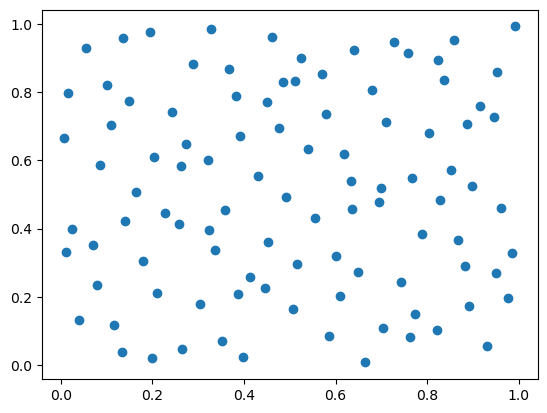

In [29]:
import matplotlib.pyplot as plt
sob_data = generator_points(100, 2, 42, "sobol", 0.1)
x = sob_data[:,0]
y = sob_data[:,1]
plt.plot(x,y,'o')
plt.show()

In [30]:
type(sob_data)

torch.Tensor

In [33]:
# add square domain
class SquareDomain:
    def __init__(self, output_dimension, time_dimensions, space_dimensions, list_of_BC, extrema_values, type_of_points, parameters_values=None, vel_wave=None):
        print(parameters_values)
        self.output_dimension = output_dimension
        self.time_dimensions = time_dimensions
        self.space_dimensions = space_dimensions
        self.list_of_BC = list_of_BC
        self.extrema_values = extrema_values if parameters_values is None else torch.cat([extrema_values, parameters_values],0)
        self.type_of_points = type_of_points
        self.input_dimensions = self.extrema_values.shape[0]
        self.extrema_0 = self.extrema_values[:, 0]
        self.extrema_f = self.extrema_values[:, 1]
        self.vel_wave = vel_wave

        self.BC = list()

    def add_collocation_points(self, n_coll, random_seed):

        x_coll = generator_points(n_coll, self.input_dimensions, random_seed, self.type_of_points, False)
        print(f"type: {type(x_coll)}")
        print(f"shape: {x_coll.shape}")
        x_coll = x_coll * (self.extrema_f - self.extrema_0) + self.extrema_0
        y_coll = torch.full((n_coll, self.output_dimension), np.nan) # placeholder for the output ???
        return x_coll, y_coll

    def add_boundary_points(self, n_boundary, random_seed):
        x_list_b = list()
        y_list_b = list()

        for i in range(self.time_dimensions, self.time_dimensions + self.space_dimensions):
            BC_01 = list()
            val_0 = np.delete(self.extrema_values, i, 0)[:, 0]
            val_f = np.delete(self.extrema_values, i, 0)[:, 1]
            x_boundary_0 = generator_points(n_boundary, self.input_dimensions, random_seed, "sobol", True)

            x_boundary_0[:, i] = torch.full(size=(n_boundary,), fill_value=0.0)
            x_boundary_0_wo_i = np.delete(x_boundary_0, i, 1)

            [y_boundary_0, type_BC] = self.list_of_BC[i - self.time_dimensions][0](x_boundary_0_wo_i * (val_f - val_0) + val_0)

            BC_01.append(type_BC)
            x_list_b.append(x_boundary_0)
            y_list_b.append(y_boundary_0)
            x_boundary_1 = generator_points(n_boundary, self.input_dimensions, random_seed, "sobol", True)
            x_boundary_1[:, i] = torch.tensor(()).new_full(size=(n_boundary,), fill_value=1.0)
            x_boundary_1_wo_i = np.delete(x_boundary_1, i, 1)

            [y_boundary_1, type_BC] = self.list_of_BC[i - self.time_dimensions][1](
                x_boundary_1_wo_i * (val_f - val_0) + val_0)
            BC_01.append(type_BC)

            self.BC.append(BC_01)

            x_list_b.append(x_boundary_1)
            y_list_b.append(y_boundary_1)

        x_b = torch.cat(x_list_b, 0)
        y_b = torch.cat(y_list_b, 0)

        x_b = x_b * (self.extrema_f - self.extrema_0) + self.extrema_0
        return x_b, y_b

    def apply_boundary_conditions(self, model, x_b_train, u_b_train, u_pred_var_list, u_train_var_list):

        for j in range(self.output_dimension):
            for i in range(self.space_dimensions):
                half_len_x_b_train_i = int(x_b_train.shape[0] / (2 * self.space_dimensions))

                x_b_train_i = x_b_train[i * int(x_b_train.shape[0] / self.space_dimensions):(i + 1) * int(x_b_train.shape[0] / self.space_dimensions), :]
                u_b_train_i = u_b_train[i * int(x_b_train.shape[0] / self.space_dimensions):(i + 1) * int(x_b_train.shape[0] / self.space_dimensions), :]

                boundary = 0
                while boundary < 2:
                    x_b_train_i_half = x_b_train_i[half_len_x_b_train_i * boundary:half_len_x_b_train_i * (boundary + 1), :]
                    u_b_train_i_half = u_b_train_i[half_len_x_b_train_i * boundary:half_len_x_b_train_i * (boundary + 1), :]

                    x_half_1 = x_b_train_i_half
                    x_half_2 = x_b_train_i[half_len_x_b_train_i * (boundary + 1):half_len_x_b_train_i * (boundary + 2), :]

                    boundary_conditions = self.BC[i][boundary][j]
                    boundary = boundary_conditions.apply(model, x_half_1, u_b_train_i_half, j, u_pred_var_list, u_train_var_list, space_dim = i,  x_boundary_sym=x_half_2, boundary=boundary, vel_wave=self.vel_wave)

                    boundary = boundary + 1
list_of_bc = []
extrema_values = torch.tensor([[0, 1], [0, 1], [0,1]])
sd = SquareDomain(1,1,2, list_of_bc, extrema_values, type_of_points="sobol")  

None


tensor([1, 1, 1])

In [35]:
sd.add_collocation_points(2**7, 42)

sobol
type: <class 'torch.Tensor'>
shape: torch.Size([128, 3])


(tensor([[0.9844, 0.3281, 0.0469],
         [0.4844, 0.8281, 0.5469],
         [0.3594, 0.4531, 0.4219],
         [0.8594, 0.9531, 0.9219],
         [0.6094, 0.2031, 0.6719],
         [0.1094, 0.7031, 0.1719],
         [0.0781, 0.2344, 0.2656],
         [0.5781, 0.7344, 0.7656],
         [0.8281, 0.4844, 0.5156],
         [0.3281, 0.9844, 0.0156],
         [0.4531, 0.3594, 0.8906],
         [0.9531, 0.8594, 0.3906],
         [0.7031, 0.1094, 0.1406],
         [0.2031, 0.6094, 0.6406],
         [0.1406, 0.4219, 0.0781],
         [0.6406, 0.9219, 0.5781],
         [0.8906, 0.1719, 0.8281],
         [0.3906, 0.6719, 0.3281],
         [0.2656, 0.0469, 0.7031],
         [0.7656, 0.5469, 0.2031],
         [0.5156, 0.2969, 0.4531],
         [0.0156, 0.7969, 0.9531],
         [0.0234, 0.3984, 0.4453],
         [0.5234, 0.8984, 0.9453],
         [0.7734, 0.1484, 0.6953],
         [0.2734, 0.6484, 0.1953],
         [0.3984, 0.0234, 0.8203],
         [0.8984, 0.5234, 0.3203],
         [0.6484, 0.

In [101]:
get_mgrid(32,3)[35]

tensor([0.0000, 0.0032, 0.0097])

# Siren implementation
Does implementation for the sine periodic function as described in the paper
""

In [39]:
class SineLayer(torch.nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(torch.nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        # coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output       

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

## New layer architecture (Giulio)


In [9]:
class ComplexHeatEquationNet(torch.nn.Module):
    def __init__(self):
        super(ComplexHeatEquationNet, self).__init__()
        self.fc1 = torch.nn.Linear(3, 512)
        self.ln1 = torch.nn.LayerNorm(512)
        self.silu1 = torch.nn.SiLU()
        self.fc2 = torch.nn.Linear(512, 256)
        self.ln2 = torch.nn.LayerNorm(256)
        self.silu2 = torch.nn.SiLU()
        self.fc3 = torch.nn.Linear(256, 128)
        self.ln3 = torch.nn.LayerNorm(128)
        self.silu3 = torch.nn.SiLU()
        self.fc4 = torch.nn.Linear(128, 64)
        self.ln4 = torch.nn.LayerNorm(64)
        self.silu4 = torch.nn.SiLU()
        self.fc5 = torch.nn.Linear(64, 32)
        self.ln5 = torch.nn.LayerNorm(32)
        self.silu5 = torch.nn.SiLU()
        self.fc6 = torch.nn.Linear(32, 1)

    def forward(self, X):
        x = self.silu1(self.ln1(self.fc1(X)))
        x = self.silu2(self.ln2(self.fc2(x)))
        x = self.silu3(self.ln3(self.fc3(x)))
        x = self.silu4(self.ln4(self.fc4(x)))
        x = self.silu5(self.ln5(self.fc5(x)))
        x = self.fc6(x)
        return x

Material properties for this case:

In [40]:
ρ = 7860; Cp = 624; k = 30.1
γ = 2.5e+4; P = 1e+5; r0 = 0.005; y_min=0.0; y_max = 0.1; x_min = 0.0; x_max = 0.1;
κ = k/(ρ * Cp)
T0 = 300.0

Differential model for this equation is very similar as for one-dimensional case.
* predict out based on the coordinates $x, y$ and time $t$.

In [70]:
learn_rate = 0.01
class Net:
    def __init__(self, model="diff"):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.device = device
        # build model
        if model == "diff":
            self.model = DiffNet(
                input_size=3,
                hidden_size=128,
                output_size=1,
                depth=5,
                act=torch.nn.Tanh).to(device)
        elif model == "complex":
            self.model = ComplexHeatEquationNet().to(device)
        elif model == "siren":
            self.model = Siren(in_features=3, out_features=1, hidden_features=256, 
                   hidden_layers=5, outermost_linear=True).to(device)
        #mydata = MyDataset(256)
        mydata = generator_points(2**16, 3, 42, "sobol", 0.1)
        self.dataloader = DataLoader(mydata, batch_size=128, pin_memory=True, num_workers=0, shuffle=True)
        
        # Initial and boundary conditions, we first create the 
        # meshgrid for x and y coordinates. The mesh is regular 
        # grid with h and k steps.
        self.h = 0.002
        self.k = 0.002
        self.dt = 0.002
        
        self.N_src_samples = 100
        self.velocity = 0.02
        self.source_coords = torch.tensor([0.05,0.05])

        x = torch.arange(0, 0.1 + self.h, self.h)
        y = torch.arange(0, 0.1 + self.k, self.k)
        t = torch.arange(0, 0.1 + self.dt, self.dt)
        
        
        xmin_bc = torch.stack(torch.meshgrid(x[0],y,t)).reshape(3,-1).T
        xmax_bc = torch.stack(torch.meshgrid(x[-1],y,t)).reshape(3,-1).T
        ymin_bc = torch.stack(torch.meshgrid(x,y[0],t)).reshape(3,-1).T
        ymax_bc = torch.stack(torch.meshgrid(x,y[-1],t)).reshape(3,-1).T
        #print(f"xmin_bc requires grad: {xmin_bc.is_leaf}")
        ic = torch.stack(torch.meshgrid(x,y,t[0])).reshape(3,-1).T
        
        # make training bcs
        self.bc_train = torch.cat([ic, xmin_bc, xmax_bc, ymin_bc, ymax_bc]) # @ivt note this are all boundary conditions
        # self.bc_train = torch.cat([ic, xmin_bc, xmax_bc, ymin_bc])
        self.bc_train = self.bc_train.to(device)
        #print(f"bc_train : {self.bc_train.shape}")
        
        self.X = torch.stack(torch.meshgrid(x,y,t)).reshape(3,-1).T.to(device)
        N_src_samples = self.N_src_samples
        sample_source_coords = torch.zeros(N_src_samples, 2)
        sample_source_coords_r = r0 * torch.rand(N_src_samples,1).sqrt()
        sample_source_coords_theta = 2 * np.pi * torch.rand(N_src_samples, 1)
        sample_source_coords_x = sample_source_coords_r * torch.cos(sample_source_coords_theta) \
                                + self.source_coords[0]
        sample_source_coords_y = sample_source_coords_r * torch.sin(sample_source_coords_theta) \
                                + self.source_coords[1]
        sample_source_coords = torch.cat([sample_source_coords_x, sample_source_coords_y],dim=1)
        self.X[-self.N_src_samples:, :2] = sample_source_coords
        self.X.requires_grad = True
        #print(f"X shape: {self.X.shape}")
        
        self.all_zeros = torch.zeros_like(self.X).to(device)
        self.all_zeros.requires_grad = False
        
        #initial and boundary condition 
        u_init = torch.zeros(len(ic))
        u_xmin = torch.ones(len(xmin_bc))*T0
        u_xmax = torch.ones(len(xmax_bc))*T0
        u_ymin = torch.ones(len(ymax_bc))*T0
        u_ymax = torch.ones(len(ymin_bc))*T0
        
        self.u_train = torch.cat([u_init, u_xmin, u_xmax, u_ymin, u_ymax])
        # self.u_train = torch.cat([u_init, u_xmin, u_xmax, u_ymin])
        self.u_train = self.u_train.unsqueeze(1)
        self.u_train = self.u_train.to(device)
        
        self.mse_cost_function = nn.MSELoss()
        self.optimizer = torch.optim.LBFGS(self.model.parameters(),lr=learn_rate,max_iter=500,max_eval=50000,
                                  history_size=50,tolerance_grad=1e-5,tolerance_change=1.0 * np.finfo(float).eps)
        self.optimizer_Adam = torch.optim.Adam(self.model.parameters())
        self.epochs = 100000
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer_Adam, self.epochs)
        self.iter = 0
        
    def source(self): 
        return 2*P/(torch.pi*r0**2)*torch.exp(-2/(r0**2)*((self.X[:,0]-self.source_coords[0])**2 + (self.X[:,1]-self.source_coords[1])**2))

    def f(self):
        u = self.model(self.X)
     
        u_dX = torch.autograd.grad(
            u, self.X, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_x = u_dX[:,0]
        u_y = u_dX[:,1]
        u_t = u_dX[:,2]
        
       
        
        u_dXX = torch.autograd.grad(
            u_dX, self.X, 
            grad_outputs=torch.ones_like(u_dX),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_xx = u_dXX[:,0]
        u_yy = u_dXX[:,1]
        
        return u_t - κ*u_xx - κ*u_yy - 1/(ρ * Cp) * self.source()
    
    def loss_func(self):
        self.optimizer_Adam.zero_grad()
        # initial and boundary conditions
        out = self.model(self.bc_train)
        mse_u = self.mse_cost_function(out, self.u_train)
        
        # fix condition for PDE
        out = self.f()
        mse_f = self.mse_cost_function(out, torch.zeros_like(out))
    
        #loss = mse_u + mse_u_xmax + mse_u_xmin + mse_u_ymax + mse_u_ymin + mse_f
        loss = mse_f + mse_u
        loss.backward()
        
        if self.iter % 100 == 0:
            print(f" Iter: {self.iter}, loss:{loss.data}")
            
        self.iter += 1
        return loss
    
    def closure(self):
           
        self.optimizer.zero_grad()
        # initial and boundary conditions
        out = self.model(self.bc_train)
        mse_u = self.mse_cost_function(out, self.u_train)
        
        # fix condition for PDE
        out = self.f()
        mse_f = self.mse_cost_function(out, torch.zeros_like(out))
    
        loss = mse_f + mse_u
        loss.backward()
        if self.iter % 100 == 0:
            print(f" LFBGS Iter: {self.iter}, loss:{loss.data}")
            
        self.iter += 1
        return loss

    def train(self,epochs, use_lbfgs = True):
        for epoch in range(epochs):
            self.X = next(iter(self.dataloader))
            # always ensure the source is in the batch
            N_src_samples = self.N_src_samples
            sample_source_coords = torch.zeros(N_src_samples, 2)
            sample_source_coords_r = 2*r0 * torch.rand(N_src_samples,1).sqrt()
            sample_source_coords_theta = 2 * np.pi * torch.rand(N_src_samples, 1)
            sample_source_coords_x = sample_source_coords_r * torch.cos(sample_source_coords_theta) \
                                + self.source_coords[0]
            sample_source_coords_y = sample_source_coords_r * torch.sin(sample_source_coords_theta) \
                                + self.source_coords[1]
            sample_source_coords = torch.cat([sample_source_coords_x, sample_source_coords_y],dim=1)
            self.X[-self.N_src_samples:, :2] = sample_source_coords
            self.X = self.X.to(self.device)
            self.X.requires_grad = True
            #self.optimizer_Adam.step(self.loss_func)

            if use_lbfgs:
                self.optimizer.step(self.closure)
            else:
                self.optimizer_Adam.step(self.loss_func)
                self.scheduler.step()
            
        


We now the train the network using first Adam optimizer followed by the LFBGS optimizer.

In [72]:
net = Net(model="complex")
net.train(100000, use_lbfgs=False)

sobol
 Iter: 0, loss:92816.359375
 Iter: 100, loss:83633.25
 Iter: 200, loss:86338.9296875
 Iter: 300, loss:79185.171875
 Iter: 400, loss:71089.9921875
 Iter: 500, loss:74187.640625
 Iter: 600, loss:72757.1015625
 Iter: 700, loss:65606.5
 Iter: 800, loss:56577.7109375
 Iter: 900, loss:58788.34375
 Iter: 1000, loss:59225.09375
 Iter: 1100, loss:58232.3125
 Iter: 1200, loss:51856.0546875
 Iter: 1300, loss:46606.32421875
 Iter: 1400, loss:41503.265625
 Iter: 1500, loss:40961.1484375
 Iter: 1600, loss:37422.12890625
 Iter: 1700, loss:34016.203125
 Iter: 1800, loss:32474.9921875
 Iter: 1900, loss:34582.69921875
 Iter: 2000, loss:31407.640625
 Iter: 2100, loss:32014.53125
 Iter: 2200, loss:23581.12109375
 Iter: 2300, loss:30494.673828125
 Iter: 2400, loss:32263.2421875
 Iter: 2500, loss:28517.87890625
 Iter: 2600, loss:31081.98046875
 Iter: 2700, loss:26017.462890625
 Iter: 2800, loss:28134.583984375
 Iter: 2900, loss:27888.3359375
 Iter: 3000, loss:26818.30078125
 Iter: 3100, loss:22750.142

In [62]:
net.train(10000)

 Iter: 10100, loss:24866.51171875
 Iter: 10200, loss:30233.978515625
 Iter: 10300, loss:29102.86328125
 Iter: 10400, loss:27519.8046875
 Iter: 10500, loss:27364.0625
 Iter: 10600, loss:28095.11328125
 Iter: 10700, loss:35052.9140625
 Iter: 10800, loss:26161.76953125
 Iter: 10900, loss:24333.3984375
 Iter: 11000, loss:27554.125
 Iter: 11100, loss:28224.599609375
 Iter: 11200, loss:21008.0
 Iter: 11300, loss:26312.58984375
 Iter: 11400, loss:31568.7578125
 Iter: 11500, loss:28922.30859375
 Iter: 11600, loss:23673.0546875
 Iter: 11700, loss:30663.765625
 Iter: 11800, loss:25156.671875
 Iter: 11900, loss:25076.265625
 Iter: 12000, loss:27205.626953125
 Iter: 12100, loss:30840.6875
 Iter: 12200, loss:23945.3828125
 Iter: 12300, loss:28219.90625
 Iter: 12400, loss:35311.92578125
 Iter: 12500, loss:28585.38671875
 Iter: 12600, loss:33502.4375
 Iter: 12700, loss:25229.1953125
 Iter: 12800, loss:24548.537109375
 Iter: 12900, loss:25490.1640625
 Iter: 13000, loss:26319.1484375
 Iter: 13100, loss

mydata: tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0008],
        [0.0000, 0.0000, 0.0016],
        ...,
        [0.1000, 0.0984, 0.1000],
        [0.1000, 0.0992, 0.0000],
        [0.1000, 0.0992, 0.0008]])


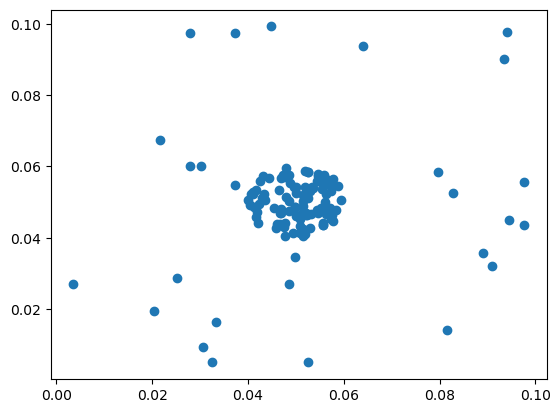

In [174]:
import matplotlib.pyplot as plt
dataloader = DataLoader(mydata, batch_size=128, pin_memory=True, num_workers=0, shuffle=True)
print(f"mydata: {mydata[:-254]}")
#X = next(iter(dataloader))
X = net.X
X = X.detach()
#print(f"returned x: {X}")
x = X[:,0].cpu()
y = X[:,1].cpu()
#x = x.detach().numpy()
#y = y.detach().numpy()
plt.plot(x,y,'o')
plt.show()

In [56]:
net.train(10000)

 Iter: 21000, loss:20609.69921875
 Iter: 21100, loss:10180.544921875
 Iter: 21200, loss:9009.0556640625
 Iter: 21300, loss:55229.734375
 Iter: 21400, loss:30882.65625
 Iter: 21500, loss:29988.0
 Iter: 21600, loss:24518.76171875
 Iter: 21700, loss:19414.14453125
 Iter: 21800, loss:21181.93359375
 Iter: 21900, loss:21640.23828125
 Iter: 22000, loss:21765.08203125
 Iter: 22100, loss:24644.05078125
 Iter: 22200, loss:22625.12890625
 Iter: 22300, loss:19393.615234375
 Iter: 22400, loss:25558.205078125
 Iter: 22500, loss:20669.20703125
 Iter: 22600, loss:19899.728515625
 Iter: 22700, loss:21560.490234375
 Iter: 22800, loss:19670.20703125
 Iter: 22900, loss:22341.36328125
 Iter: 23000, loss:19665.74609375
 Iter: 23100, loss:22053.748046875
 Iter: 23200, loss:20614.046875
 Iter: 23300, loss:23031.421875
 Iter: 23400, loss:20918.77734375
 Iter: 23500, loss:21613.62890625
 Iter: 23600, loss:19903.8671875
 Iter: 23700, loss:17006.376953125
 Iter: 23800, loss:23213.14453125
 Iter: 23900, loss:2166

In [121]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Now lets try to plot the current solution of the equation.

shape: (21, 21, 21)


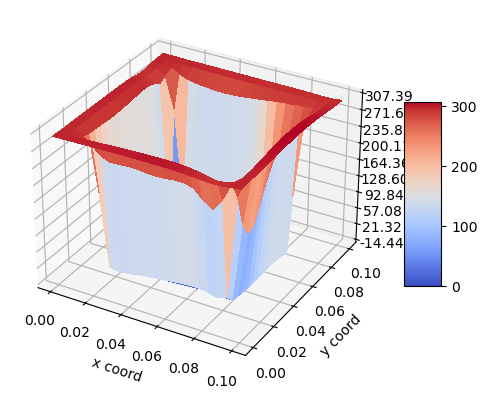

In [73]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure()
ax = plt.axes(projection='3d')
dx = 0.005
x = torch.arange(0,0.1+dx,dx)
y = torch.arange(0,0.1+dx,dx)
t = torch.ones_like(x)*0.04
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
X = torch.stack(torch.meshgrid(x,y,t)).reshape(3,-1).T.to(device)


u_pred = net.model(X)
um = u_pred.data.cpu().numpy()
um = um.reshape(x.shape[0],y.shape[0],t.shape[0])

x = np.arange(0,0.1+dx,dx)
y = np.arange(0,0.1+dx,dx)
xm, ym = np.meshgrid(x,y)

print(f"shape: {um.shape}")

surf = ax.plot_surface(xm, ym, um[:,:,3], cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_ylabel("y coord")
ax.set_xlabel("x coord")
#ax.view_init(elev=90, azim=-90, roll = 0)
fig.colorbar(surf, shrink=.5, aspect=5)
plt.show()

In [74]:
def solution(x,y,t):
    return np.exp(x + y) * np.cos(x + y + 4*t)
anal_sol = solution(x,y,2)
mse=np.mean((anal_sol-u_pred.data.cpu().numpy())**2)


In [75]:
mse

41693.156909377416

In [ ]:
x.shape[0]

In [ ]:
u_pred.shape